In [2]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn 
import torch.optim as optim 

In [4]:
import urllib.request
import zipfile
import os

URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
ZIP_PATH = "UCI_HAR_Dataset.zip"
EXTRACT_DIR = "data"

if not os.path.exists(ZIP_PATH):
    print("Downloading UCI HAR dataset...")
    urllib.request.urlretrieve(URL, ZIP_PATH)


if not os.path.exists(os.path.join(EXTRACT_DIR, "UCI HAR Dataset")):
    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)

print("Done.")


Done.


In [5]:
import numpy as np
import os

BASE = "data/UCI HAR Dataset"

def load_har(split="train"):
    base = os.path.join(BASE, split, "Inertial Signals")
    signals = [
        "body_acc_x", "body_acc_y", "body_acc_z",
        "body_gyro_x", "body_gyro_y", "body_gyro_z",
        "total_acc_x", "total_acc_y", "total_acc_z",
    ]

    X = []
    for s in signals:
        X.append(
            np.loadtxt(os.path.join(base, f"{s}_{split}.txt"))
        )

    X = np.stack(X, axis=-1)              # (N, 128, 9)
    y = np.loadtxt(
        os.path.join(BASE, split, f"y_{split}.txt")
    ) - 1                                 # Labels 0..5

    return X.astype("float32"), y.astype("int32")


In [6]:
X_train, y_train = load_har("train")
X_test,  y_test  = load_har("test")

print(X_train.shape)  # (7352, 128, 9)
print(y_train.shape)  # (7352,)

mean = X_train.mean(axis=(0, 1), keepdims=True)
std  = X_train.std(axis=(0, 1), keepdims=True) + 1e-6

X_train = (X_train - mean) / std
X_test  = (X_test  - mean) / std


(7352, 128, 9)
(7352,)


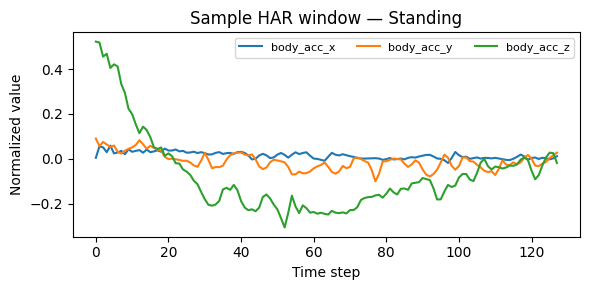

In [7]:
import matplotlib.pyplot as plt

class_names = [
    'Walking',
    'Walking Upstairs',
    'Walking Downstairs',
    'Sitting',
    'Standing',
    'Laying',
]

idx = 0  # change to view a different sample
t = range(X_train.shape[1])
activity = class_names[int(y_train[idx])]

plt.figure(figsize=(6, 3))
plt.plot(t, X_train[idx, :, 0], label='body_acc_x')
plt.plot(t, X_train[idx, :, 1], label='body_acc_y')
plt.plot(t, X_train[idx, :, 2], label='body_acc_z')
plt.xlabel('Time step')
plt.ylabel('Normalized value')
plt.title(f'Sample HAR window — {activity}')
plt.legend(fontsize=8, ncol=3)
plt.tight_layout()
plt.show()


In [8]:
from torch.utils.data import TensorDataset, DataLoader

BATCH = 64
device = "mps" # or mps or cuda or cpu

train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).long())
test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test).long())

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False) # (BATCH, 128, 9 )

In [37]:
class hRNN(nn.Module):
    def __init__(self, num_classes=6, input_size = 9, hidden_size = 32, drop_rate=0.5, fc_size = 128): # 9 sensors, 6 classes, size of h_t is 32
        super().__init__()

        # this is feature extractor (automated)
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True) # if batch_first = False -> (128, BATCH, 9 ) 
                                                                     # if batch_first = True -> (BATCH, 128, 9)
        
        
        # this is classifier
        self.fc1 = nn.Linear(hidden_size, fc_size)
        self.bn = nn.BatchNorm1d(fc_size)
        self.drop = nn.Dropout(drop_rate)
        self.fc2 = nn.Linear(fc_size , num_classes) 
    
    def forward(self, x):
        out, _ = self.rnn(x) 
        out = out[:,-1,:] # flatten
        out = torch.relu(self.fc1(out))
        out = self.bn(out)
        out = self.drop(out)
        return self.fc2(out)

model = hRNN(input_size=9, hidden_size=128, num_classes=6).to(device)

In [36]:
def train_rnn(patience=5, lr = 1e-3):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) # Adam is a modern gradient method 

    epochs = 30 
    #patience = 5 # Patience is the number of consecutive epochs without improvement that we allow before stopping training. 
    best_val_loss = float("inf")
    patience_left = patience 
    best_state = None

    history = {"train_loss":[], "val_loss": [], "train_acc" : [], "val_acc": []}

    for epoch in range(1, epochs +1):
        model.train()
        train_loss = .0
        train_correct = 0
        train_count = 0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss_out = loss(logits, yb)
            loss_out.backward()
            optimizer.step()

            batch_size = xb.size(0)
            train_loss += loss_out.item() * batch_size
            train_correct += (logits.argmax(dim=1) == yb).sum().item() # number of correctly classified
            train_count += batch_size

        train_loss /= train_count
        train_acc  = train_correct/train_count

        model.eval() # Test data
        val_loss = 0.0
        val_correct = 0
        val_count = 0

        with torch.no_grad():
            for xb,yb in test_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                logits = model(xb)
                loss_out = loss(logits,yb)

                batch_size = xb.size(0)
                val_loss += loss_out.item() * batch_size
                val_correct += (logits.argmax(dim=1) == yb).sum().item() # number of correctly classified
                val_count += batch_size
        
        val_loss /= val_count
        val_acc  = val_correct/val_count 

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch:02d} | train_loss={train_loss:.4f} acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f} acc={val_acc:.4f}"
        )

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()} # save the weights 
            patience_left = patience
        else:
            patience_left -=1 
            if patience_left==0:
                print("Early stopping")
                break
        
        if best_state is not None:
            model.load_state_dict(best_state)
    return best_val_acc 

# Hyperparameter optimization

In [ ]:
#patience_list = [3,5,7]
#lr_list = [1e-2, 1e-3, 1e-4]
hidden_list = [16, 32, 64,128,256]
#dropout_list = [0.2,0.3,0.4,0.5]
fc_list = [64, 128, 256]

# Grid Search -> check every combination 
results = {}
for h in hidden_list:
    for fc in fc_list:
        model = hRNN(input_size=9,hidden_size=h, fc_size=fc).to(device)
        results[(h,fc)] = train_rnn()

In [ ]:
results

In [33]:
# Random Search 
import random

patience_list = [3,5,7]
lr_list = [1e-2, 1e-3, 1e-4]
hidden_list = [16, 32, 64,128,256]
dropout_list = [0.2,0.3,0.4,0.5]
fc_list = [64, 128, 256]

n_trials = 7

results_random = {}

for _ in range(n_trials):
    patience = random.choice(patience_list)
    lr = random.choice(lr_list)
    h = random.choice(hidden_list)
    drop = random.choice(dropout_list)
    fc = random.choice(fc_list)
    model = hRNN(hidden_size=h, drop_rate=drop, fc_size=fc).to(device)
    results_random[(patience,lr,h,drop,fc)] = train_rnn(patience=patience, lr=lr)


Epoch 01 | train_loss=1.5640 acc=0.4013 | val_loss=1.2782 acc=0.5144
Epoch 02 | train_loss=1.1221 acc=0.5764 | val_loss=1.0751 acc=0.5507
Epoch 03 | train_loss=0.9496 acc=0.6326 | val_loss=0.9613 acc=0.5911
Epoch 04 | train_loss=0.8567 acc=0.6498 | val_loss=0.8892 acc=0.6216
Epoch 05 | train_loss=0.7871 acc=0.6751 | val_loss=0.8349 acc=0.6366
Epoch 06 | train_loss=0.7457 acc=0.6945 | val_loss=0.7940 acc=0.6546
Epoch 07 | train_loss=0.7012 acc=0.7084 | val_loss=0.7726 acc=0.6671
Epoch 08 | train_loss=0.6724 acc=0.7212 | val_loss=0.7520 acc=0.6759
Epoch 09 | train_loss=0.6487 acc=0.7292 | val_loss=0.7304 acc=0.6895
Epoch 10 | train_loss=0.6304 acc=0.7352 | val_loss=0.7243 acc=0.6875
Epoch 11 | train_loss=0.6106 acc=0.7413 | val_loss=0.7164 acc=0.6888
Epoch 12 | train_loss=0.5942 acc=0.7490 | val_loss=0.7073 acc=0.6956
Epoch 13 | train_loss=0.5840 acc=0.7544 | val_loss=0.6977 acc=0.6983
Epoch 14 | train_loss=0.5673 acc=0.7655 | val_loss=0.6927 acc=0.7014
Epoch 15 | train_loss=0.5576 acc=0

In [34]:
results_random

{(7, 0.0001, 16, 0.2, 256): 0.7268408551068883,
 (5, 0.01, 128, 0.4, 128): 0.7787580590430947,
 (3, 0.001, 32, 0.5, 128): 0.7505938242280285,
 (5, 0.01, 128, 0.3, 64): 0.6182558534102477,
 (3, 0.01, 256, 0.5, 128): 0.5459789616559213,
 (7, 0.001, 128, 0.4, 64): 0.8561248727519511,
 (3, 0.01, 128, 0.4, 128): 0.6216491347132678}

In [38]:
train_rnn()

Epoch 01 | train_loss=0.8085 acc=0.7005 | val_loss=0.6807 acc=0.7686
Epoch 02 | train_loss=0.4008 acc=0.8564 | val_loss=0.3669 acc=0.8887
Epoch 03 | train_loss=0.1847 acc=0.9319 | val_loss=0.2455 acc=0.9060
Epoch 04 | train_loss=0.1433 acc=0.9429 | val_loss=0.2380 acc=0.9199
Epoch 05 | train_loss=0.1255 acc=0.9487 | val_loss=0.3032 acc=0.9040
Epoch 06 | train_loss=0.1320 acc=0.9460 | val_loss=0.2517 acc=0.9080
Epoch 07 | train_loss=0.1414 acc=0.9434 | val_loss=0.2976 acc=0.9074
Epoch 08 | train_loss=0.1275 acc=0.9472 | val_loss=0.6028 acc=0.8161
Epoch 09 | train_loss=0.1360 acc=0.9456 | val_loss=0.2676 acc=0.9111
Early stopping


0.9199185612487275

In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix

model.eval()
all_logits = []

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        all_logits.append(logits.cpu().numpy())

logits = np.concatenate(all_logits, axis=0)
y_pred = np.argmax(logits, axis=1)

cm = confusion_matrix(y_test, y_pred)
cm


array([[496,   0,   0,   0,   0,   0],
       [  0, 447,  19,   5,   0,   0],
       [  3,   4, 412,   1,   0,   0],
       [  0,  27,   0, 366,  98,   0],
       [  0,  45,   0,  60, 427,   0],
       [  0,   0,   0,   0,   0, 537]])

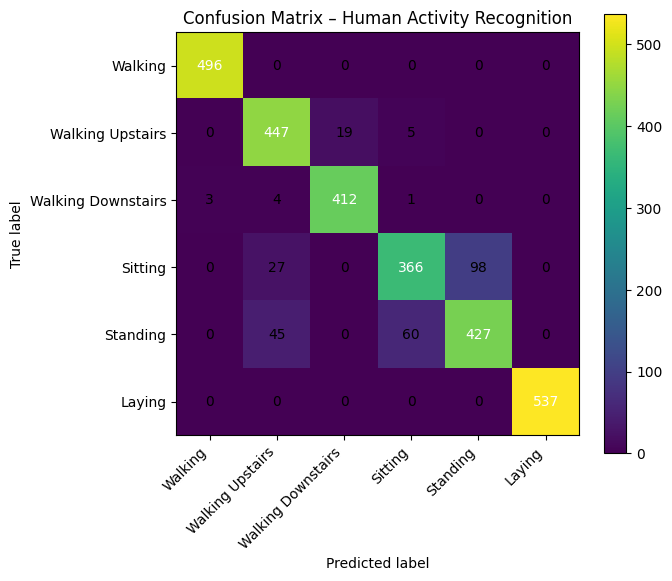

In [40]:
import matplotlib.pyplot as plt

class_names = [
    "Walking",
    "Walking Upstairs",
    "Walking Downstairs",
    "Sitting",
    "Standing",
    "Laying",
]

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm)

ax.set_xticks(range(len(class_names)))
ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix – Human Activity Recognition")

# Werte einzeichnen
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black")

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()
